# AMATERASU tutorial

In this notebook, how to run AMATERASU. Let's start by importing it.

In [2]:
import sys
import os

sys.path.append(os.path.abspath(".."))

from amaterasu.AMATERASU import AMATERASU

The indice table contains 9 predefined spectral lines predefined: 3 of K I, 2 of Ti I, 2 of Al I, 2 of Mn I and 1 of Fe I. The suffix "a" or "b" only serves to identify the lines more easily. "ln_win" and "interp_win" are the maximum central bandpass and interpolation/continuum windows, respectively. These are merely suggestions and may be changed at will.

In [4]:
import pandas as pd

ind_table = pd.read_csv("../ind_table.csv")
ind_table

,ln_id,ln_ctr,ln_win,interp_win
0,KI_a,11772.862,3,9
1,KI_b,12435.647,4,12
2,KI_c,12525.544,4,12
3,AlI_a,13127.011,5,15
4,AlI_b,13154.345,5,15
5,FeI,11693.408,4,12
6,MnI,12903.289,4,12
7,TiI_a,10498.989,3,9
8,TiI_b,12825.181,3,9


Let's run AMATERASU in NIRPS observations of Proxima Centauri. The way you extract the data is irrelevant, as long the final arrays to feed the tool have the dimensions printed below and are RV corrected. We also note that the data we used are telluric corrected.

In [5]:
from astropy.io import fits
import numpy as np

with fits.open("Proxima_NIRPS_observations.fits") as hdul:
    print(hdul.info())
    bjd_observations = hdul["BJD"].data
    fwhm_array = hdul["FWHM"].data
    table_data = hdul["SPECTRA"].data

    n_obs = len(table_data)
    n_orders, n_pix = 71, 4084 #expected shape

    waves = np.array([row['wavelengths'].reshape((n_orders, n_pix)) for row in table_data])
    fluxes = np.array([row['fluxes'].reshape((n_orders, n_pix)) for row in table_data])
    flux_errors = np.array([row['flux_errors'].reshape((n_orders, n_pix)) for row in table_data])

    #final shape: (137, 3, 71, 4084)
    spectra_observations = np.stack([waves, fluxes, flux_errors], axis=1)

Filename: Proxima_NIRPS_observations.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  BJD           1 ImageHDU         7   (137,)   float64   
  2  FWHM          1 ImageHDU         8   (2, 137)   float64   
  3  SPECTRA       1 BinTableHDU     15   137R x 3C   [289964D, 289964D, 289964D]   
None


In [6]:
print("CCF FWHM array shape: ",fwhm_array.shape)
print("BJD array shape: ",bjd_observations.shape)
print("spectra observations array shape: ",spectra_observations.shape)


CCF FWHM array shape:  (137, 2)
BJD array shape:  (137,)
spectra observations array shape:  (137, 3, 71, 4084)


We will test two spectral lines: K I (b) and (c). The input periods will be value close to the literature rotation period with an uncertainty, the tolerance will be 10 d and the FAP threshold for detection is 0.1%.

For the correlations, we will test with the CCF FWHM of NIRPS observations, using a treshold of $\rho_S \geq 0.4$ and p-val of 0.1% for the absolute correlation to be considered "strong".

Below all input for AMATERASU is shown.

In [7]:
#options for AMATERASU

star = "Proxima" #star name

data = [bjd_observations, spectra_observations]

run_gls = True
#periods that will be tested. two of them close to the real rotation period of Proxima and one close to the orbital period of Proxima b
period_test = [[80,5],[85,8],[11,2]]
ptol = [10,10,2] #10 days of tolerance for higher periods, 2 for the lower
fap_treshold = 0.001
plot_gls=True 
gls_options = [run_gls, period_test, ptol, fap_treshold, plot_gls]


run_correlation=True
df_fwhm = pd.DataFrame({"BJD":bjd_observations,"fwhm":fwhm_array[:,0],"fwhm_err":fwhm_array[:,1]})
cols_input = ["fwhm"]
cols_err_input = ["fwhm_err"]
abs_corr_threshold=0.4
pval_threshold=0.001
correlation_options = [run_correlation, df_fwhm, cols_input, cols_err_input, abs_corr_threshold, pval_threshold]

#spectral lines to be tested:

indices = ["KI_b","KI_c"]

indice_info = {
                "KI_b":{'ln_ctr':12435.647},
                "KI_c":{'ln_ctr':12525.544},
                }

Now let's run the "standard" version of AMATERASU, the simplest. We give the star name, data, lines names and centers, options for GLSPs and correlations and the folder to save.

AMATERASU instance created for Proxima


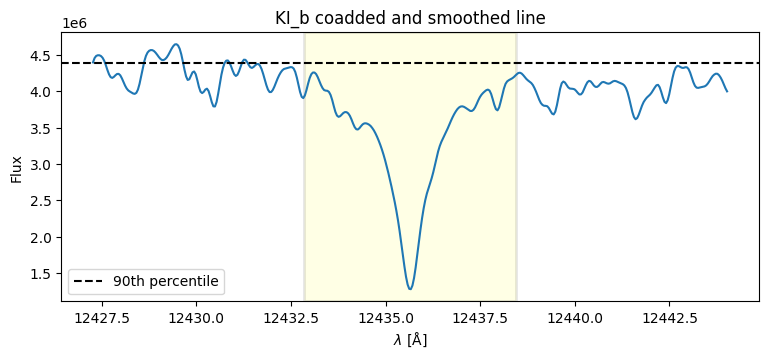

--------------------------------------------------------------------------------
Computing Equivalent-Widths.
Line ID: KI_b
Line center: 12435.647
Number of spectra: 137
--------------------------------------------------------------------------------
Maximum Bandpass: 5.6
Interpolation window: 16.8
--------------------------------------------------------------------------------


100%|██████████| 137/137 [00:24<00:00,  5.53it/s]


Computing GLS Periodograms for all bandpasses.


100%|██████████| 56/56 [00:01<00:00, 39.22it/s]


Bandpass with period near to input and lowest FAP: 2.2
Period [d]: 79.05477413118251
FAP: 5.90e-19
    bandpass                period                        FAP input_period
0        0.1  (79.47248076909325,)   (8.517519927301531e-13,)     [80, 85]
1        0.2  (79.89462497928172,)  (3.0692278900455966e-13,)     [80, 85]
2        0.3   (84.3765635621279,)   (0.0004607070529385069,)     [80, 85]
3        0.4  (82.98005592096179,)   (5.444836229884314e-09,)     [80, 85]
4        0.5  (85.82088068530248,)   (8.379958965261617e-07,)     [80, 85]
5        0.6  (91.01399204253029,)   (0.0002201182915897598,)         [85]
6        0.7  (94.44289513041403,)  (3.4435817237657414e-05,)         [85]
7        0.8  (77.42695268769103,)   (8.436577887059803e-07,)     [80, 85]
8        0.9  (77.82759079774885,)   (2.383922957472711e-09,)     [80, 85]
9        1.0   (78.2323965976698,)   (7.025588152251707e-12,)     [80, 85]
10       1.1  (78.64143545987739,)   (5.072942248593972e-14,)     [80, 85]
1

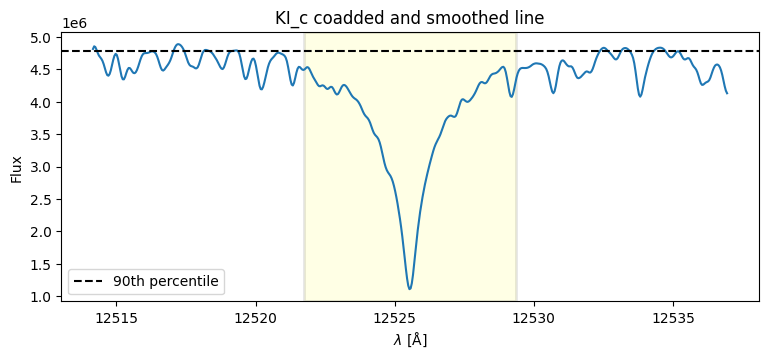

--------------------------------------------------------------------------------
Computing Equivalent-Widths.
Line ID: KI_c
Line center: 12525.544
Number of spectra: 137
--------------------------------------------------------------------------------
Maximum Bandpass: 7.6
Interpolation window: 22.8
--------------------------------------------------------------------------------


100%|██████████| 137/137 [00:32<00:00,  4.28it/s]


Computing GLS Periodograms for all bandpasses.


100%|██████████| 76/76 [00:01<00:00, 38.67it/s]


Bandpass with period near to input and lowest FAP: 2.6
Period [d]: 79.89462497928167
FAP: 9.55e-18
    bandpass                period                        FAP input_period
0        0.1  (79.89462497928172,)  (2.6108473380889566e-14,)     [80, 85]
1        0.2  (80.32127785425143,)   (1.197022765004547e-11,)     [80, 85]
2        0.3  (81.62902254262609,)  (1.0507829361212112e-06,)     [80, 85]
3        0.6  (78.23239659766982,)   (4.569365730501412e-06,)     [80, 85]
4        0.7   (78.6414354598774,)  (1.8494311637576456e-08,)     [80, 85]
..       ...                   ...                        ...          ...
69       7.2  (79.89462497928172,)   (2.228039750352293e-11,)     [80, 85]
70       7.3  (79.89462497928172,)  (3.3196208818951847e-11,)     [80, 85]
71       7.4  (79.89462497928172,)  (3.5623530369436754e-11,)     [80, 85]
72       7.5  (79.89462497928172,)   (4.320904375273939e-11,)     [80, 85]
73       7.6  (79.89462497928172,)   (5.684482024932373e-11,)     [80, 85]



In [9]:
amaterasu = AMATERASU(star, data, indices, indice_info, gls_options, correlation_options, 
                      output="standard", 
                      folder_path=f"tutorial_results_standard/", 
                      plot_line=True)

As we can see, both lines are able to detect Proxima's rotation period quite nicely in the majority of central bandpasses, as well as strong correlation with the CCF FWHM of NIRPS.

Finally, let's test AMATERASU with the "full" output.

AMATERASU instance created for Proxima


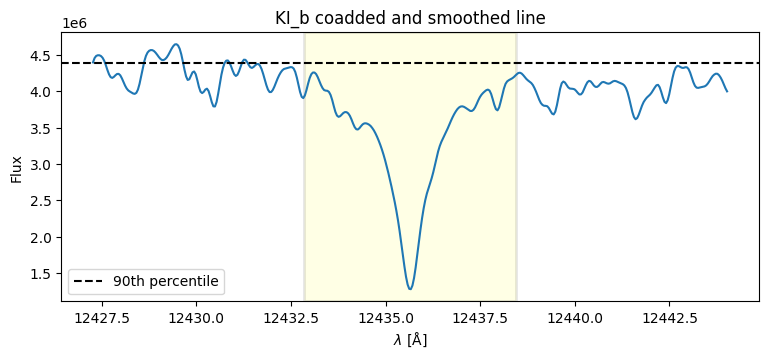

--------------------------------------------------------------------------------
Computing Equivalent-Widths.
Line ID: KI_b
Line center: 12435.647
Number of spectra: 137
--------------------------------------------------------------------------------
Maximum Bandpass: 5.6
Interpolation window: 16.8
--------------------------------------------------------------------------------


100%|██████████| 137/137 [00:21<00:00,  6.30it/s]


Computing GLS Periodograms for all bandpasses.


100%|██████████| 56/56 [01:24<00:00,  1.50s/it]


Bandpass with period near to input and lowest FAP: 2.2
Period [d]: 79.05477413118251
FAP: 5.90e-19
    bandpass                period                        FAP input_period
0        0.1  (79.47248076909325,)   (8.517519927301531e-13,)     [80, 85]
1        0.2  (79.89462497928172,)  (3.0692278900455966e-13,)     [80, 85]
2        0.3   (84.3765635621279,)   (0.0004607070529385069,)     [80, 85]
3        0.4  (82.98005592096179,)   (5.444836229884314e-09,)     [80, 85]
4        0.5  (85.82088068530248,)   (8.379958965261617e-07,)     [80, 85]
5        0.6  (91.01399204253029,)   (0.0002201182915897598,)         [85]
6        0.7  (94.44289513041403,)  (3.4435817237657414e-05,)         [85]
7        0.8  (77.42695268769103,)   (8.436577887059803e-07,)     [80, 85]
8        0.9  (77.82759079774885,)   (2.383922957472711e-09,)     [80, 85]
9        1.0   (78.2323965976698,)   (7.025588152251707e-12,)     [80, 85]
10       1.1  (78.64143545987739,)   (5.072942248593972e-14,)     [80, 85]
1

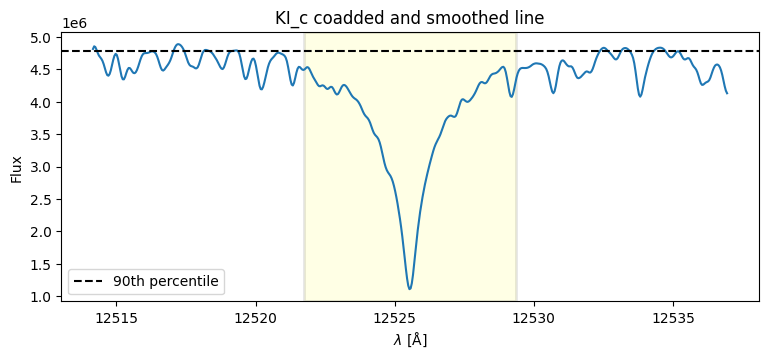

--------------------------------------------------------------------------------
Computing Equivalent-Widths.
Line ID: KI_c
Line center: 12525.544
Number of spectra: 137
--------------------------------------------------------------------------------
Maximum Bandpass: 7.6
Interpolation window: 22.8
--------------------------------------------------------------------------------


100%|██████████| 137/137 [00:33<00:00,  4.06it/s]


Computing GLS Periodograms for all bandpasses.


100%|██████████| 76/76 [02:23<00:00,  1.89s/it]


Bandpass with period near to input and lowest FAP: 2.6
Period [d]: 79.89462497928167
FAP: 9.55e-18
    bandpass                period                        FAP input_period
0        0.1  (79.89462497928172,)  (2.6108473380889566e-14,)     [80, 85]
1        0.2  (80.32127785425143,)   (1.197022765004547e-11,)     [80, 85]
2        0.3  (81.62902254262609,)  (1.0507829361212112e-06,)     [80, 85]
3        0.6  (78.23239659766982,)   (4.569365730501412e-06,)     [80, 85]
4        0.7   (78.6414354598774,)  (1.8494311637576456e-08,)     [80, 85]
..       ...                   ...                        ...          ...
69       7.2  (79.89462497928172,)   (2.228039750352293e-11,)     [80, 85]
70       7.3  (79.89462497928172,)  (3.3196208818951847e-11,)     [80, 85]
71       7.4  (79.89462497928172,)  (3.5623530369436754e-11,)     [80, 85]
72       7.5  (79.89462497928172,)   (4.320904375273939e-11,)     [80, 85]
73       7.6  (79.89462497928172,)   (5.684482024932373e-11,)     [80, 85]



In [10]:
amaterasu = AMATERASU(star, data, indices, indice_info, gls_options, correlation_options,
                    output="full", 
                    plot_line=True, folder_path="tutorial_results_full")

As a final exercise, let's plot the period with lowest FAP for each central bandpass of each line in function of the central bandpass.

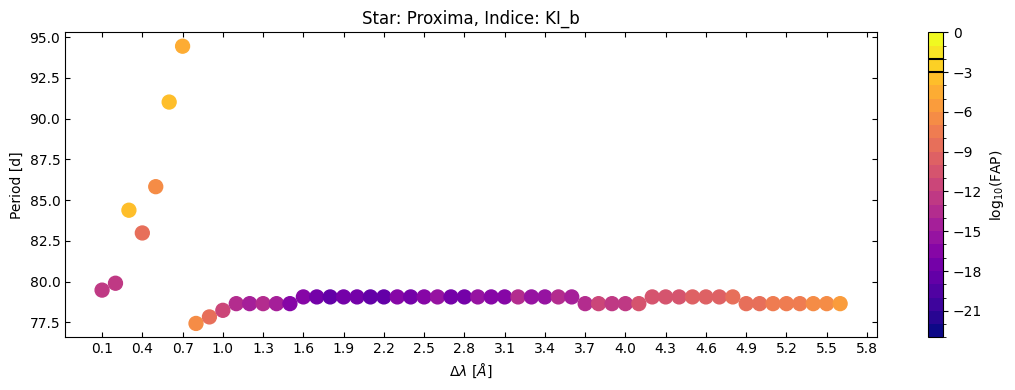

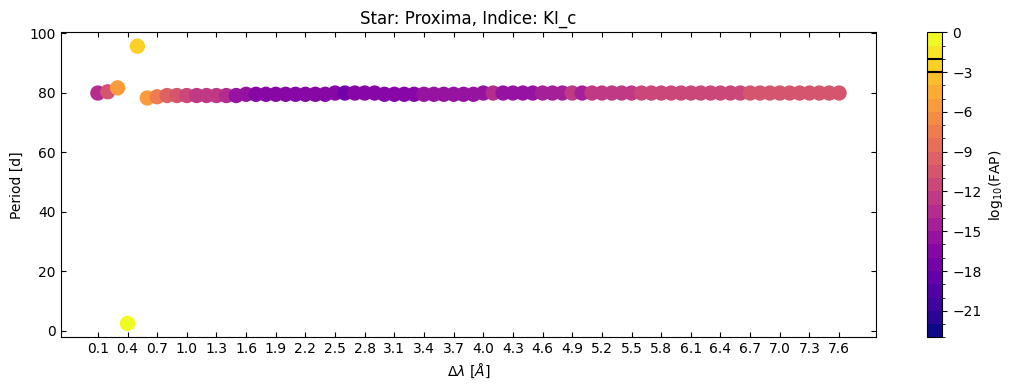

In [12]:
import ast
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors 

def periods_bandpass_plot(star, indice):

    df_gls = pd.read_csv(f"tutorial_results_full/{star}/{indice}/periods_full_{star}_{indice}.csv")
    cmap = plt.get_cmap("plasma")
    log_FAP_min, log_FAP_max = 0, -23
    boundaries = np.arange(log_FAP_max, log_FAP_min + 1, 1)  # Intervals of 1
    norm = mcolors.BoundaryNorm(boundaries, cmap.N, clip=True)

    fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(11, 4))

    axes.set_title(f"Star: {star}, Indice: {indice}")

    periods = []; faps = []
    for i in range(len(df_gls["sel_peaks_period"])):
        periods.append(ast.literal_eval(df_gls["sel_peaks_period"][i])[0])
        faps.append(ast.literal_eval(df_gls["sel_peaks_FAP"][i])[0])

    bandpasses = np.array(range(1,len(df_gls["sel_peaks_period"])+1))/10
    sc1 = axes.scatter(bandpasses, periods, c=np.log10(faps), cmap=cmap, marker="o", s=100, norm=norm)

    axes.set_xlabel(r"$\Delta \lambda$ [$\AA$]"); axes.set_ylabel(r"Period [d]")
    cbar = fig.colorbar(sc1, ax=axes, label=r"log$_{10}$(FAP)")
    cbar.ax.axhline(y=np.log10(0.001), color='black', linestyle="-", linewidth=1.5)
    cbar.ax.axhline(y=np.log10(0.01), color='black', linestyle="-", linewidth=1.5)

    axes.set_xticks(np.arange(np.min(bandpasses),np.max(bandpasses)+0.3,0.3))
    axes.tick_params(axis="both", direction="in", top=True, right=True, which="both")
    plt.tight_layout()

for ind in indices:
    periods_bandpass_plot(star, ind)

plt.show()

Let's do the same but for the Spearman correlation with CCF FWHM (NIRPS).

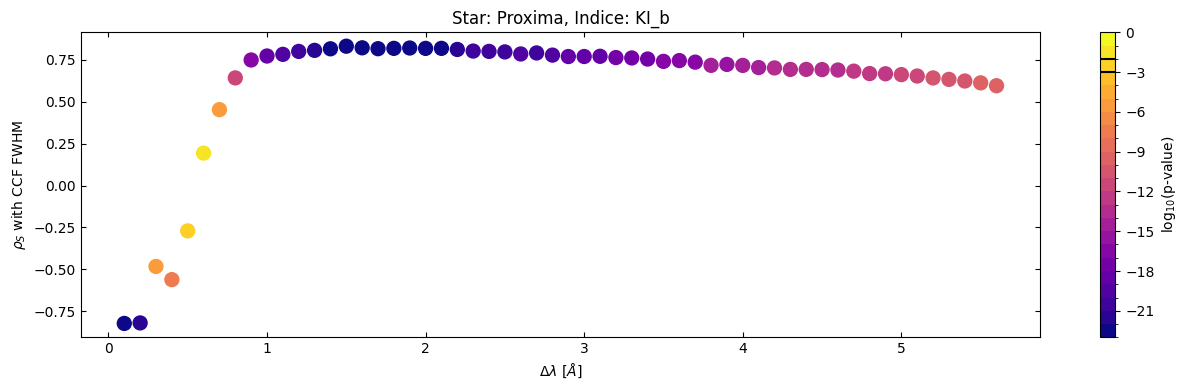

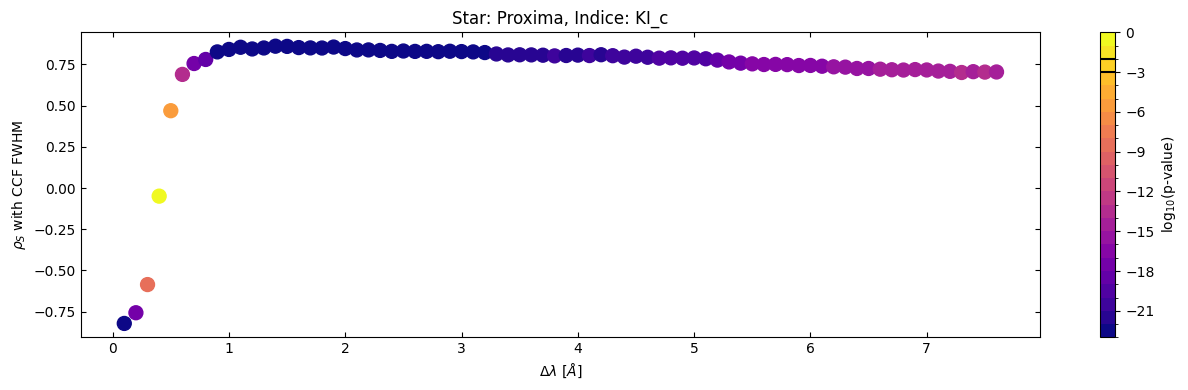

In [13]:
def correlation_bandpass_plot(star, indice):

    df_correlations = pd.read_csv(f"tutorial_results_full/{star}/{indice}/correlations_{star}_{indice}.csv")

    cmap = plt.get_cmap("plasma")
    log_pval_min, log_pval_max = 0, -23
    boundaries = np.arange(log_pval_max, log_pval_min + 1, 1)  # Intervals of 1
    norm = mcolors.BoundaryNorm(boundaries, cmap.N, clip=True)

    fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(13, 4))

    axes.set_title(f"Star: {star}, Indice: {indice}")
    sc1 = axes.scatter(df_correlations["bandpass"], df_correlations["rho_fwhm"], c=np.log10(df_correlations["pval_fwhm"]), cmap=cmap, marker="o", s=100, norm=norm)

    axes.set_xlabel(r"$\Delta \lambda$ [$\AA$]")
    axes.set_ylabel(r"$\rho_S$ with CCF FWHM")
    cbar = fig.colorbar(sc1, ax=axes, label=r"log$_{10}$(p-value)")
    cbar.ax.axhline(y=np.log10(0.001), color='black', linestyle="-", linewidth=1.5)
    cbar.ax.axhline(y=np.log10(0.01), color='black', linestyle="-", linewidth=1.5)

    axes.tick_params(axis="both", direction="in", top=True, right=True, which="both")
    plt.tight_layout()

for ind in indices:
    correlation_bandpass_plot(star, ind)

plt.show()